# Solving eigenvalue problems using Neural Network

In this jupyter notebook it will be demonstrated how we obtain our results in the report that corresponds to finding the eigenvalues of a given matrix. 

First off, we will need to import some libraries.

In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import cm
from matplotlib import pyplot as plt
from matplotlib import rc
from mpl_toolkits.mplot3d import axes3d
import tqdm as tqdm
from matplotlib import rc

/home/oliver/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/oliver/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/oliver/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/oliver/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: 

Then, we would like the format of the figures to be neat and in correct font. 

In [2]:
#Latex font for plots
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rc('font', family='serif')
plt.rcParams.update({'font.size': 10}) # Setting all font sizes

We can then make two different arrays where the analytical eigenvalues of one of them are already known. 

In [3]:
is_it_known = True 
matrix_size = 6

if is_it_known==True:
    # Defining analytical eigenvalues
    j = np.linspace(1,matrix_size,matrix_size)
    jpi = j*np.pi
    x_analytic = 2-2*tf.cos(jpi/(len(j)+1))
    
    # Defining a 6x6 matrix with only zeros
    A = np.zeros((matrix_size, matrix_size))
    
    for i in range(0,matrix_size-1):
        A[i][i+1] = -1
        A[i][i] = 2
        A[i+1][i] = -1

    A[matrix_size-1][matrix_size-1] = 2
    
if is_it_known==False:
    A = np.random.random_sample((matrix_size,matrix_size))
    A = (A.T + A)/2.

# Finding analytical eigenvector using Numpy
numpy_eigenvalue, numpy_vector = np.linalg.eig(A)
print(A)

[[ 2. -1.  0.  0.  0.  0.]
 [-1.  2. -1.  0.  0.  0.]
 [ 0. -1.  2. -1.  0.  0.]
 [ 0.  0. -1.  2. -1.  0.]
 [ 0.  0.  0. -1.  2. -1.]
 [ 0.  0.  0.  0. -1.  2.]]


The program under runs the neural network and tries to estimate the eigenvalue of the matrix given above. 

It is worth to mention that tensorflow does not allow to reuse the tensors, so with a re-run one should also restart the kernel.

In [4]:
# Defining variables
run_iter = 100
num_iter = 100000
num_hidden_neurons = [100] # Number of hidden neurons in each layer
lambdas = np.zeros((run_iter,num_iter))

I = np.identity(matrix_size)
dt = np.ones(matrix_size)
x0 = np.random.rand(matrix_size)
x0 = x0/np.sqrt(np.sum(x0*x0)) #normalized

# The construction phase
I_tf = tf.convert_to_tensor(I)
x0_tf = tf.convert_to_tensor(np.random.random_sample(size = (1,matrix_size)))
dt_tf = tf.reshape(tf.convert_to_tensor(dt),shape=(-1,1))


with tf.variable_scope('dnn'):
    num_hidden_layers = np.size(num_hidden_neurons)

    previous_layer = x0_tf

    for l in range(num_hidden_layers):
        current_layer = tf.layers.dense(previous_layer, num_hidden_neurons[l],activation=tf.nn.sigmoid)
        previous_layer = current_layer

    dnn_output = tf.layers.dense(previous_layer, matrix_size)

def cost_func(x):

    xTxA = (tf.tensordot(tf.transpose(x), x, axes=1)*A)
    xTAxI = (1- tf.tensordot(tf.transpose(x), tf.tensordot(A, x, axes=1), axes=1))*np.eye(6)
    f = tf.tensordot((xTxA + xTAxI), x, axes=1)

    return(f)  # x(t))

for runs in tqdm.tqdm(range(run_iter)):
    with tf.name_scope('loss'):

        x_trial = tf.transpose(dnn_output)  # x(t)
        right_side = tf.transpose(cost_func(x_trial))
        x_trial = tf.transpose(x_trial)  # x(t)
        
        # Define the cost function
        loss = tf.losses.mean_squared_error(right_side, x_trial)

    ## Can also use Gradient descent, but will need to uncomment learning_rate as well.
    #learning_rate = 1e-1
    with tf.name_scope('train'):
        #optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        optimizer = tf.train.AdamOptimizer()
        
        training_op = optimizer.minimize(loss)

    init = tf.global_variables_initializer()

    x_dnn = None

    num_iter_needed = []
    x_trial_list = np.zeros((num_iter,6))
    ## The execution phase
    with tf.Session() as sess:
        init.run()
        for i in range(num_iter):
            sess.run(training_op)

            eigenvalue = (x_trial.eval() @ (A @ x_trial.eval().T)
                        /(x_trial.eval() @ x_trial.eval().T))[0,0]

            lambdas[runs][i] = eigenvalue

            x_dnn = x_trial.eval()
            x_dnn = x_dnn.T

            ## Normalize g_trials for comparing to normalized numpy solution
            x_dnn = x_dnn/np.sqrt(np.sum(x_dnn*x_dnn))
            l = loss.eval()
            
            #if i % 1000 == 0:
                #print("Step:", i, "/",num_iter, "loss: ", l, "Eigenvalue:" , eigenvalue)
            if l==0:#<1e-16:
                x_trial_list[i:]=x_trial_list[i-1]
                lambdas[runs][i:]=eigenvalue
                num_iter_needed.append(i)
                break

            for l in range(matrix_size):
                x_trial_list[i][l] =  x_dnn[l]

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


  0%|          | 0/100 [00:00<?, ?it/s]

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


100%|██████████| 100/100 [15:17<00:00,  9.17s/it]


Next up is visualization of the result.


 Numpy Eigenvalues: 
 [3.80193774 3.2469796  2.44504187 0.19806226 1.55495813 0.7530204 ]

 Final Numerical Eigenvalue 
 1.5549581320873735


Absolute difference between Numpy Eigenvalue and TensorFlow DNN =  2.6645352591003757e-15
numpy vec: [ 0.41790651 -0.52112089 -0.23192061 -0.41790651  0.23192061  0.52112089]
computed vec [[ 0.5211209   0.2319206  -0.41790654 -0.41790648  0.23192064  0.52112087]]


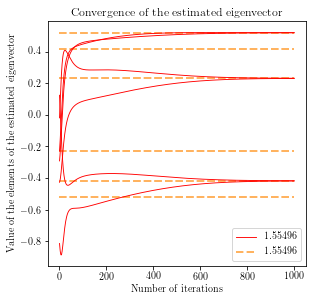

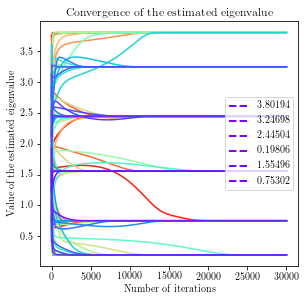

In [21]:
# Visualization
color=iter(cm.rainbow(np.linspace(1,0,5)))
c = next(color)
fig = plt.figure();
w = 5.78851          # Latex document text width
fig.set_size_inches(w=w*0.8,h= 4.5)
tmp_xaxis = 30000
tmp_xaxis1 = 1000
for k in range(matrix_size):
    
    if k==0:
        plt.plot(np.linspace(1,tmp_xaxis1,tmp_xaxis1),x_trial_list[:tmp_xaxis1,k],c=c,label="%2.5f" % eigenvalue,linewidth=0.9)
    else:
        plt.plot(np.linspace(1,tmp_xaxis1,tmp_xaxis1),x_trial_list[:tmp_xaxis1,k],c=c,linewidth=0.9)

## Compare with the analytical solution
print("\n Numpy Eigenvalues: \n", numpy_eigenvalue)
print("\n Final Numerical Eigenvalue \n", eigenvalue)
diff = np.min(abs(numpy_eigenvalue - eigenvalue))
print("\n")
print('Absolute difference between Numpy Eigenvalue and TensorFlow DNN = ',np.max(diff))

# Finding which element of analytic our estimated eigenvalue converges to
index = np.argmin(abs(numpy_eigenvalue - eigenvalue))

print("numpy vec:", numpy_vector[index])
print("computed vec",x_dnn.T)

c = next(color)
for l in range(matrix_size):
    plt.hlines(numpy_vector[index][l],0,tmp_xaxis1,colors=c,linestyles="dashed",linewidth=2)
    if l==(matrix_size-1):
        plt.hlines(-numpy_vector[index][l],0,tmp_xaxis1,colors=c,linestyles="dashed",label="%2.5f" % numpy_eigenvalue[index],linewidth=2)
        break
    plt.hlines(-numpy_vector[index][l],0,tmp_xaxis1,colors=c,linestyles="dashed",linewidth=2)
plt.xlabel("Number of iterations")
plt.ylabel("Value of the elements of the estimated eigenvector")
plt.legend()
plt.title("Convergence of the estimated eigenvector")
plt.savefig("plots/eigenvalue_solver/convergence_eigenvector.pgf")

plt.show()

color=iter(cm.rainbow(np.linspace(1,0,run_iter+1)))
fig = plt.figure();
w = 5.78851          # Latex document text width
fig.set_size_inches(w=w*0.8,h= 4.5)


iterations=np.linspace(1,tmp_xaxis,tmp_xaxis)
for i in range(runs+1):
    plt.plot(iterations,lambdas[i][:tmp_xaxis],c=c)
    c=next(color)

for l in range(matrix_size):
    plt.hlines(numpy_eigenvalue[l],0,num_iter,colors=c,linestyles="dashed",label="%2.5f" % numpy_eigenvalue[l],linewidth=2,)
plt.legend(loc="center right")
plt.xlabel("Number of iterations")
plt.ylabel("Value of the estimated eigenvalue")
plt.title("Convergence of the estimated eigenvalue")
plt.savefig("plots/eigenvalue_solver/convergence_eigenvalue.pgf")
plt.show()

As seen, the values in the estimated eigenvector does not exactly converge towards numpys eigenvector when we are using a random symmetric matrix, but does however yield the exact eigenvalue. It is the eigenvalue that we are after, and since it is exact, we do not dwell about the values in the eigenvector. 

Number of mean iterations needed: 1682.0


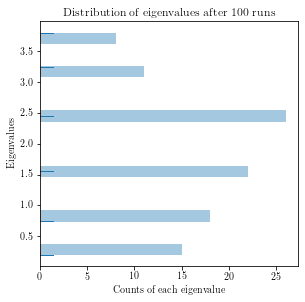

In [23]:
import seaborn as sns
fig = plt.figure();
w = 5.78851          # Latex document text width
fig.set_size_inches(w=w*0.8,h= 4.5)

plt.xlabel("Counts of each eigenvalue")
plt.ylabel("Eigenvalues")
plt.title("Distribution of eigenvalues after %2.0f runs" %(run_iter))
data= np.reshape(lambdas[:,-1],[1,int(run_iter)])
sns.distplot(data,kde=False, norm_hist=False, bins = 20, rug=True,vertical=True)
plt.savefig("plots/eigenvalue_solver/histogram.pgf")

print("Number of mean iterations needed:", np.mean(num_iter_needed))